# Testing `mlrun.handler` Decorator

Notebook for testing the functionalities of the `mlrun` decorator:
* Setting labels
* Parsing inputs - converting `mlrun.DataItem`s to their configured / type hinted type.
* Logging outputs - logging the returning function values to MLRun according to the configured / default artifact type.

Tests are separated into the following:
1. Setting labels
2. Logging outputs
3. Parsing inputs
4. Raising errors
5. Supporting class methods

All tests are running in 3 ways:
1. Without MLRun to see the decorator was transparent .
2. With MLRun locally.
3. With MLRun remotly as a job.

## General Configurations

In [1]:
import os
import sys
import tempfile
import zipfile

import cloudpickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

import mlrun

In [2]:
# Path to the functions code:
FUNCTIONS_SCRIPT = os.path.abspath("./functions.py")

# Load all functions to call locally:
sys.path.append(FUNCTIONS_SCRIPT)
from functions import *

In [3]:
# Create the project:
project = mlrun.get_or_create_project(name="mlrun-handler-tests", context="./", user_project=True)

# Create the function out of the script:
mlrun_function = mlrun.code_to_function(filename=FUNCTIONS_SCRIPT, kind="job", image="mlrun/mlrun")

> 2023-01-10 17:55:09,276 [info] loaded project mlrun-handler-tests from ./ and saved in MLRun DB


## 1. Setting Labels

### 1.1. Set labels

Run the `set_labels` function to see the wrapper is setting the required labels.

In [4]:
def test_set_labels_without_mlrun():
    returned_result = set_labels(24)
    assert returned_result == 1

    returned_result = set_labels(20, 18)
    assert returned_result == 2

    returned_result = set_labels(arg1=24)
    assert returned_result == 1

    returned_result = set_labels(arg1=20, arg2=18)
    assert returned_result == 2


def test_set_labels_with_mlrun(local: bool):
    # Run the function:
    run_object = mlrun_function.run(
        handler="set_labels",
        params={"arg1": 24},
        local=local,
    )

    # Manual validation:
    mlrun.utils.logger.info(run_object.metadata.labels)

    # Assertion:
    assert run_object.metadata.labels["a"] == "1"
    assert run_object.metadata.labels["b"] == "a test"
    assert run_object.metadata.labels["c"] == "[1, 2, 3]"

In [5]:
test_set_labels_without_mlrun()
test_set_labels_with_mlrun(local=True)
test_set_labels_with_mlrun(local=False)

> 2023-01-10 17:55:14,145 [info] starting run functions-set_labels uid=134767246ac14b78977b59947dd8a4e5 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...7dd8a4e5,0,Jan 10 17:55:14,completed,functions-set_labels,"v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-qxpvka=1b=a testc=[1, 2, 3]",,arg1=24,,


> 2023-01-10 17:55:14,381 [info] run executed, status=completed
> 2023-01-10 17:55:14,382 [info] {'v3io_user': 'guyl', 'kind': '', 'owner': 'guyl', 'host': 'jupyter-guyl-65dfdbf79-qxpvk', 'a': '1', 'b': 'a test', 'c': '[1, 2, 3]'}
> 2023-01-10 17:55:14,417 [info] starting run functions-set_labels uid=18b46dbf54654b0684848475982346c1 DB=http://mlrun-api:8080
> 2023-01-10 17:55:14,663 [info] Job is running in the background, pod: functions-set-labels-n5mc6
> 2023-01-10 17:55:20,044 [info] To track results use the CLI: {'info_cmd': 'mlrun get run 18b46dbf54654b0684848475982346c1 -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs 18b46dbf54654b0684848475982346c1 -p mlrun-handler-tests-guyl'}
> 2023-01-10 17:55:20,044 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.cto-office.iguazio-cd1.com/mlprojects/mlrun-handler-tests-guyl/jobs/monitor/18b46dbf54654b0684848475982346c1/overview'}
> 2023-01-10 17:55:20,044 [info] run executed, status=completed
final state: comp

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...982346c1,0,Jan 10 17:55:18,completed,functions-set_labels,"v3io_user=guylkind=jobowner=guylmlrun/client_version=1.2.1host=functions-set-labels-n5mc6a=1b=a testc=[1, 2, 3]",,arg1=24,,


> 2023-01-10 17:55:20,877 [info] run executed, status=completed
> 2023-01-10 17:55:20,877 [info] {'v3io_user': 'guyl', 'kind': 'job', 'owner': 'guyl', 'mlrun/client_version': '1.2.1', 'host': 'functions-set-labels-n5mc6', 'a': '1', 'b': 'a test', 'c': '[1, 2, 3]'}


### 1.2. Set Labels from Function and Wrapper

Run the `set_labels_from_function_and_wrapper` function to see the wrapper is setting the required labels without interrupting to the ones set via the context by the user.

In [6]:
def test_set_labels_from_function_and_wrapper_without_mlrun():
    returned_result = set_labels_from_function_and_wrapper()
    assert returned_result is None


def test_set_labels_from_function_and_wrapper_with_mlrun(local: bool):
    # Run the function:
    run_object = mlrun_function.run(
        handler="set_labels_from_function_and_wrapper",
        local=local,
    )

    # Manual validation:
    mlrun.utils.logger.info(run_object.metadata.labels)

    # Assertion:
    assert run_object.metadata.labels["context_label"] == "1"
    assert run_object.metadata.labels["wrapper_label"] == "2"

In [7]:
test_set_labels_from_function_and_wrapper_without_mlrun()
test_set_labels_from_function_and_wrapper_with_mlrun(local=True)
test_set_labels_from_function_and_wrapper_with_mlrun(local=False)

> 2023-01-10 17:55:20,962 [info] starting run functions-set_labels_from_function_and_wrapper uid=60bc36202c3e483a84ceb79cffa99a5c DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...ffa99a5c,0,Jan 10 17:55:21,completed,functions-set_labels_from_function_and_wrapper,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-qxpvkcontext_label=1wrapper_label=2,,,,


> 2023-01-10 17:55:21,117 [info] run executed, status=completed
> 2023-01-10 17:55:21,118 [info] {'v3io_user': 'guyl', 'kind': '', 'owner': 'guyl', 'host': 'jupyter-guyl-65dfdbf79-qxpvk', 'context_label': '1', 'wrapper_label': '2'}
> 2023-01-10 17:55:21,141 [info] starting run functions-set_labels_from_function_and_wrapper uid=5aba56f4cadc4c6a9cf3c151c2b6fc48 DB=http://mlrun-api:8080
> 2023-01-10 17:55:21,303 [info] Job is running in the background, pod: functions-set-labels-from-function-and-wrapper-6fbkr
> 2023-01-10 17:55:26,691 [info] To track results use the CLI: {'info_cmd': 'mlrun get run 5aba56f4cadc4c6a9cf3c151c2b6fc48 -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs 5aba56f4cadc4c6a9cf3c151c2b6fc48 -p mlrun-handler-tests-guyl'}
> 2023-01-10 17:55:26,691 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.cto-office.iguazio-cd1.com/mlprojects/mlrun-handler-tests-guyl/jobs/monitor/5aba56f4cadc4c6a9cf3c151c2b6fc48/overview'}
> 2023-01-10 17:55:26,691 [i

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...c2b6fc48,0,Jan 10 17:55:25,completed,functions-set_labels_from_function_and_wrapper,v3io_user=guylkind=jobowner=guylmlrun/client_version=1.2.1host=functions-set-labels-from-function-and-wrapper-6fbkrcontext_label=1wrapper_label=2,,,,


> 2023-01-10 17:55:27,504 [info] run executed, status=completed
> 2023-01-10 17:55:27,505 [info] {'v3io_user': 'guyl', 'kind': 'job', 'owner': 'guyl', 'mlrun/client_version': '1.2.1', 'host': 'functions-set-labels-from-function-and-wrapper-6fbkr', 'context_label': '1', 'wrapper_label': '2'}


## 2. Logging Outputs

### 2.1. Log Dataset

Run the `log_dataset` function to see the wrapper is logging the returned values as datasets artifacts.

In [8]:
def test_log_dataset_without_mlrun():
    my_array, my_df, my_dict, my_list = log_dataset()
    assert isinstance(my_array, np.ndarray)
    assert isinstance(my_df, pd.DataFrame)
    assert isinstance(my_dict, dict)
    assert isinstance(my_list, list)


def test_log_dataset_with_mlrun(local: bool):
    # Run the function:
    run_object = mlrun_function.run(
        handler="log_dataset",
        local=local,
    )

    # Manual validation:
    mlrun.utils.logger.info(run_object.outputs)

    # Assertion:
    assert len(run_object.outputs) == 4  # my_array, my_df, my_dict, my_list
    assert run_object.artifact("my_array").as_df().shape == (10, 20)
    assert run_object.artifact("my_df").as_df().shape == (20, 10)
    assert run_object.artifact("my_dict").as_df().shape == (4, 2)
    assert run_object.artifact("my_list").as_df().shape == (3, 1)

In [9]:
test_log_dataset_without_mlrun()
test_log_dataset_with_mlrun(local=True)
test_log_dataset_with_mlrun(local=False)

> 2023-01-10 17:55:27,590 [info] starting run functions-log_dataset uid=771403df357f458f8e9e2c7a27995b85 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...27995b85,0,Jan 10 17:55:27,completed,functions-log_dataset,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-qxpvk,,,,my_arraymy_dfmy_dictmy_list


> 2023-01-10 17:55:28,206 [info] run executed, status=completed
> 2023-01-10 17:55:28,206 [info] {'my_array': 'store://artifacts/mlrun-handler-tests-guyl/functions-log_dataset_my_array:771403df357f458f8e9e2c7a27995b85', 'my_df': 'store://artifacts/mlrun-handler-tests-guyl/functions-log_dataset_my_df:771403df357f458f8e9e2c7a27995b85', 'my_dict': 'store://artifacts/mlrun-handler-tests-guyl/functions-log_dataset_my_dict:771403df357f458f8e9e2c7a27995b85', 'my_list': 'store://artifacts/mlrun-handler-tests-guyl/functions-log_dataset_my_list:771403df357f458f8e9e2c7a27995b85'}
> 2023-01-10 17:55:28,428 [info] starting run functions-log_dataset uid=f9f2f38767574b858632ffccaa374b4c DB=http://mlrun-api:8080
> 2023-01-10 17:55:28,630 [info] Job is running in the background, pod: functions-log-dataset-kkkfq
> 2023-01-10 17:55:34,375 [info] To track results use the CLI: {'info_cmd': 'mlrun get run f9f2f38767574b858632ffccaa374b4c -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs f9f2f38767574b85

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...aa374b4c,0,Jan 10 17:55:32,completed,functions-log_dataset,v3io_user=guylkind=jobowner=guylmlrun/client_version=1.2.1host=functions-log-dataset-kkkfq,,,,my_arraymy_dfmy_dictmy_list


> 2023-01-10 17:55:34,869 [info] run executed, status=completed
> 2023-01-10 17:55:34,869 [info] {'my_array': 'store://artifacts/mlrun-handler-tests-guyl/functions-log_dataset_my_array:f9f2f38767574b858632ffccaa374b4c', 'my_df': 'store://artifacts/mlrun-handler-tests-guyl/functions-log_dataset_my_df:f9f2f38767574b858632ffccaa374b4c', 'my_dict': 'store://artifacts/mlrun-handler-tests-guyl/functions-log_dataset_my_dict:f9f2f38767574b858632ffccaa374b4c', 'my_list': 'store://artifacts/mlrun-handler-tests-guyl/functions-log_dataset_my_list:f9f2f38767574b858632ffccaa374b4c'}


### 2.2. Log Directory

Run the `log_directory` function to see the wrapper is logging the directory as a zip file.

In [10]:
def test_log_directory_without_mlrun():
    temp_dir = tempfile.TemporaryDirectory()
    my_dir = log_directory(temp_dir.name)
    assert isinstance(my_dir, str)
    temp_dir.cleanup()


def test_log_directory_with_mlrun(local: bool):
    # Run the function:
    output_path = tempfile.TemporaryDirectory()
    run_object = mlrun_function.run(
        handler="log_directory",
        params={"path": output_path.name},
        local=local,
    )

    # Manual validation:
    mlrun.utils.logger.info(run_object.outputs)

    # Assertion:
    assert len(run_object.outputs) == 1  # my_dir
    my_dir_zip = run_object.artifact("my_dir").local()
    my_dir = os.path.join(output_path.name, "extract_here")
    with zipfile.ZipFile(my_dir_zip, "r") as zip_ref:
        zip_ref.extractall(my_dir)
    my_dir_contents = os.listdir(my_dir)
    assert len(my_dir_contents) == 3
    assert "a.txt" in my_dir_contents
    assert "b.txt" in my_dir_contents
    assert "c.txt" in my_dir_contents
    
    # Clear the output path:
    output_path.cleanup()

In [11]:
test_log_directory_without_mlrun()
test_log_directory_with_mlrun(local=True)
test_log_directory_with_mlrun(local=False)

> 2023-01-10 17:55:35,134 [info] starting run functions-log_directory uid=5578de9f879d49c396d27503d535599a DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...d535599a,0,Jan 10 17:55:35,completed,functions-log_directory,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-qxpvk,,path=/tmp/tmpx5kzdbuz,,my_dir


> 2023-01-10 17:55:35,399 [info] run executed, status=completed
> 2023-01-10 17:55:35,400 [info] {'my_dir': 'v3io:///projects/mlrun-handler-tests-guyl/artifacts/functions-log_directory/0/my_dir.zip'}
> 2023-01-10 17:55:35,400 [info] downloading v3io:///projects/mlrun-handler-tests-guyl/artifacts/functions-log_directory/0/my_dir.zip to local temp file
> 2023-01-10 17:55:35,432 [info] starting run functions-log_directory uid=1d227832efc54e30a778930e068d9eb4 DB=http://mlrun-api:8080
> 2023-01-10 17:55:35,601 [info] Job is running in the background, pod: functions-log-directory-txxhz
> 2023-01-10 17:55:40,993 [info] To track results use the CLI: {'info_cmd': 'mlrun get run 1d227832efc54e30a778930e068d9eb4 -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs 1d227832efc54e30a778930e068d9eb4 -p mlrun-handler-tests-guyl'}
> 2023-01-10 17:55:40,993 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.cto-office.iguazio-cd1.com/mlprojects/mlrun-handler-tests-guyl/jobs/monit

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...068d9eb4,0,Jan 10 17:55:39,completed,functions-log_directory,v3io_user=guylkind=jobowner=guylmlrun/client_version=1.2.1host=functions-log-directory-txxhz,,path=/tmp/tmpxfva5wol,,my_dir


> 2023-01-10 17:55:41,820 [info] run executed, status=completed
> 2023-01-10 17:55:41,820 [info] {'my_dir': 'v3io:///projects/mlrun-handler-tests-guyl/artifacts/functions-log_directory/0/my_dir.zip'}
> 2023-01-10 17:55:41,821 [info] downloading v3io:///projects/mlrun-handler-tests-guyl/artifacts/functions-log_directory/0/my_dir.zip to local temp file


### 2.3. Log File

Run the `log_file` function to see the wrapper is logging the file.

In [12]:
def test_log_file_without_mlrun():
    temp_dir = tempfile.TemporaryDirectory()
    my_file = log_file(temp_dir.name)
    assert isinstance(my_file, str)
    temp_dir.cleanup()


def test_log_file_with_mlrun(local: bool):
    # Run the function:
    output_path = tempfile.TemporaryDirectory()
    run_object = mlrun_function.run(
        handler="log_file",
        params={"path": output_path.name},
        local=local,
    )

    # Manual validation:
    mlrun.utils.logger.info(run_object.outputs)

    # Assertion:
    assert len(run_object.outputs) == 1  # my_file
    with open(run_object.artifact("my_file").local(), "r") as text_file:
        assert text_file.read() == "MLRun decorator test."
    
    # Clear the output path:
    output_path.cleanup()

In [13]:
test_log_file_without_mlrun()
test_log_file_with_mlrun(local=True)
test_log_file_with_mlrun(local=False)

> 2023-01-10 17:55:41,916 [info] starting run functions-log_file uid=3b311cb58bf944089f32d4fe19fe7e12 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...19fe7e12,0,Jan 10 17:55:41,completed,functions-log_file,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-qxpvk,,path=/tmp/tmp4k2_m37s,,my_file


> 2023-01-10 17:55:42,158 [info] run executed, status=completed
> 2023-01-10 17:55:42,159 [info] {'my_file': 'v3io:///projects/mlrun-handler-tests-guyl/artifacts/functions-log_file/0/my_file.txt'}
> 2023-01-10 17:55:42,160 [info] downloading v3io:///projects/mlrun-handler-tests-guyl/artifacts/functions-log_file/0/my_file.txt to local temp file
> 2023-01-10 17:55:42,190 [info] starting run functions-log_file uid=347808db25134fffa2a422faf8b2e3e5 DB=http://mlrun-api:8080
> 2023-01-10 17:55:42,369 [info] Job is running in the background, pod: functions-log-file-bk6wb
> 2023-01-10 17:55:47,803 [info] To track results use the CLI: {'info_cmd': 'mlrun get run 347808db25134fffa2a422faf8b2e3e5 -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs 347808db25134fffa2a422faf8b2e3e5 -p mlrun-handler-tests-guyl'}
> 2023-01-10 17:55:47,803 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.cto-office.iguazio-cd1.com/mlprojects/mlrun-handler-tests-guyl/jobs/monitor/347808db25134f

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...f8b2e3e5,0,Jan 10 17:55:46,completed,functions-log_file,v3io_user=guylkind=jobowner=guylmlrun/client_version=1.2.1host=functions-log-file-bk6wb,,path=/tmp/tmpcb5dnw4j,,my_file


> 2023-01-10 17:55:48,606 [info] run executed, status=completed
> 2023-01-10 17:55:48,606 [info] {'my_file': 'v3io:///projects/mlrun-handler-tests-guyl/artifacts/functions-log_file/0/my_file.txt'}
> 2023-01-10 17:55:48,607 [info] downloading v3io:///projects/mlrun-handler-tests-guyl/artifacts/functions-log_file/0/my_file.txt to local temp file


### 2.4. Log Object

Run the `log_object` function to see the wrapper is logging the object as pickle.

In [14]:
def test_log_object_without_mlrun():
    temp_dir = tempfile.TemporaryDirectory()
    my_object = log_object()
    assert isinstance(my_object, Pipeline)
    assert my_object.transform([["A"], ["B"], [""]]).tolist() == [[0], [1], [2]]
    temp_dir.cleanup()


def test_log_object_with_mlrun(local: bool):
    # Run the function:
    output_path = tempfile.TemporaryDirectory()
    run_object = mlrun_function.run(
        handler="log_object",
        params={"path": output_path.name},
        local=local,
    )

    # Manual validation:
    mlrun.utils.logger.info(run_object.outputs)

    # Assertion:
    assert len(run_object.outputs) == 1  # my_file
    with open(run_object.artifact("my_object").local(), "rb") as pickle_file:
        my_object = cloudpickle.load(pickle_file)
    assert isinstance(my_object, Pipeline)
    assert my_object.transform([["A"], ["B"], [""]]).tolist() == [[0], [1], [2]]
    
    # Clear the output path:
    output_path.cleanup()

In [15]:
test_log_object_without_mlrun()
test_log_object_with_mlrun(local=True)
test_log_object_with_mlrun(local=False)

> 2023-01-10 17:55:48,696 [info] starting run functions-log_object uid=f2f932d383f140b88d2fa0ef4712b369 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...4712b369,0,Jan 10 17:55:48,completed,functions-log_object,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-qxpvk,,path=/tmp/tmp9zfxivh5,,my_object


> 2023-01-10 17:55:48,932 [info] run executed, status=completed
> 2023-01-10 17:55:48,932 [info] {'my_object': 'v3io:///projects/mlrun-handler-tests-guyl/artifacts/functions-log_object/0/my_object.pkl'}
> 2023-01-10 17:55:48,933 [info] downloading v3io:///projects/mlrun-handler-tests-guyl/artifacts/functions-log_object/0/my_object.pkl to local temp file
> 2023-01-10 17:55:48,965 [info] starting run functions-log_object uid=df3bb2eda8df4bb18c91a316fe15ecd8 DB=http://mlrun-api:8080
> 2023-01-10 17:55:49,154 [info] Job is running in the background, pod: functions-log-object-jlr7p
> 2023-01-10 17:55:54,584 [info] To track results use the CLI: {'info_cmd': 'mlrun get run df3bb2eda8df4bb18c91a316fe15ecd8 -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs df3bb2eda8df4bb18c91a316fe15ecd8 -p mlrun-handler-tests-guyl'}
> 2023-01-10 17:55:54,584 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.cto-office.iguazio-cd1.com/mlprojects/mlrun-handler-tests-guyl/jobs/monitor/

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...fe15ecd8,0,Jan 10 17:55:52,completed,functions-log_object,v3io_user=guylkind=jobowner=guylmlrun/client_version=1.2.1host=functions-log-object-jlr7p,,path=/tmp/tmp91nyjpp1,,my_object


> 2023-01-10 17:55:55,393 [info] run executed, status=completed
> 2023-01-10 17:55:55,393 [info] {'my_object': 'v3io:///projects/mlrun-handler-tests-guyl/artifacts/functions-log_object/0/my_object.pkl'}
> 2023-01-10 17:55:55,394 [info] downloading v3io:///projects/mlrun-handler-tests-guyl/artifacts/functions-log_object/0/my_object.pkl to local temp file


### 2.5. Log Plot

Run the `log_plot` function to see the wrapper is logging the plot as html files.

In [16]:
def test_log_plot_without_mlrun():
    my_plot = log_plot()
    assert isinstance(my_plot, plt.Figure)


def test_log_plot_with_mlrun(local: bool):
    # Run the function:
    run_object = mlrun_function.run(
        handler="log_plot",
        local=local,
    )

    # Manual validation:
    mlrun.utils.logger.info(run_object.outputs)

    # Assertion:
    assert len(run_object.outputs) == 1  # my_plot
    run_object.artifact("my_plot").show()

> 2023-01-10 17:55:55,664 [info] starting run functions-log_plot uid=51165f15f71b452aa1f8d163db9e6f50 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...db9e6f50,0,Jan 10 17:55:55,completed,functions-log_plot,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-qxpvk,,,,my_plot


> 2023-01-10 17:55:56,168 [info] run executed, status=completed
> 2023-01-10 17:55:56,169 [info] {'my_plot': 'v3io:///projects/mlrun-handler-tests-guyl/artifacts/functions-log_plot/0/my_plot.html'}



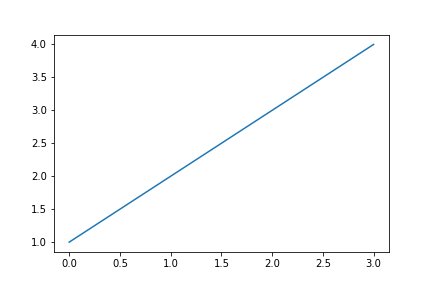

> 2023-01-10 17:55:56,203 [info] starting run functions-log_plot uid=72cc04e41e5d43f280ced5ee28ecec64 DB=http://mlrun-api:8080
> 2023-01-10 17:55:56,367 [info] Job is running in the background, pod: functions-log-plot-s5pwz
> 2023-01-10 17:56:01,991 [info] To track results use the CLI: {'info_cmd': 'mlrun get run 72cc04e41e5d43f280ced5ee28ecec64 -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs 72cc04e41e5d43f280ced5ee28ecec64 -p mlrun-handler-tests-guyl'}
> 2023-01-10 17:56:01,991 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.cto-office.iguazio-cd1.com/mlprojects/mlrun-handler-tests-guyl/jobs/monitor/72cc04e41e5d43f280ced5ee28ecec64/overview'}
> 2023-01-10 17:56:01,991 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...28ecec64,0,Jan 10 17:56:00,completed,functions-log_plot,v3io_user=guylkind=jobowner=guylmlrun/client_version=1.2.1host=functions-log-plot-s5pwz,,,,my_plot


> 2023-01-10 17:56:02,612 [info] run executed, status=completed
> 2023-01-10 17:56:02,613 [info] {'my_plot': 'v3io:///projects/mlrun-handler-tests-guyl/artifacts/functions-log_plot/0/my_plot.html'}



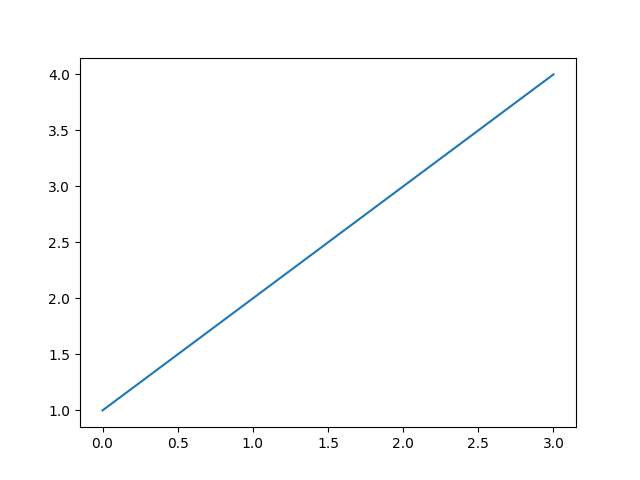

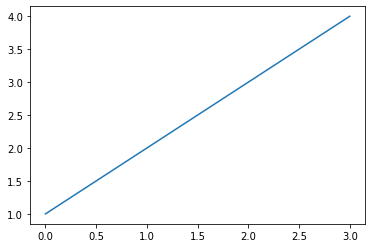

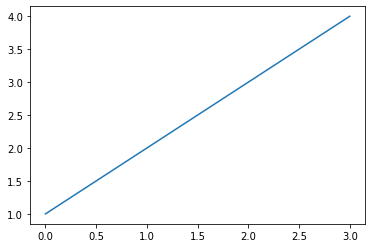

In [17]:
test_log_plot_without_mlrun()
test_log_plot_with_mlrun(local=True)
test_log_plot_with_mlrun(local=False)

### 2.6. Log Result

Run the `log_result` function to see the wrapper is logging the returned values as results.

In [18]:
def test_log_result_without_mlrun():
    my_int, my_float, my_dict, my_array = log_result()
    assert isinstance(my_int, int)
    assert isinstance(my_float, float)
    assert isinstance(my_dict, dict)
    assert isinstance(my_array, np.ndarray)


def test_log_result_with_mlrun(local: bool):
    # Run the function:
    run_object = mlrun_function.run(
        handler="log_result",
        local=local,
    )

    # Manual validation:
    mlrun.utils.logger.info(run_object.outputs)

    # Assertion:
    assert len(run_object.outputs) == 4  # my_int, my_float, my_dict, my_array
    assert run_object.outputs["my_int"] == 1
    assert run_object.outputs["my_float"] == 1.5
    assert run_object.outputs["my_dict"] == {"a": 1, "b": 2}
    assert run_object.outputs["my_array"] == [1, 1, 1]

In [19]:
test_log_result_without_mlrun()
test_log_result_with_mlrun(local=True)
test_log_result_with_mlrun(local=False)

> 2023-01-10 17:56:02,905 [info] starting run functions-log_result uid=f13318f64213430ea0102ca1f93f7453 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...f93f7453,0,Jan 10 17:56:02,completed,functions-log_result,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-qxpvk,,,"my_int=1my_float=1.5my_dict={'a': 1, 'b': 2}my_array=[1.0, 1.0, 1.0]",


> 2023-01-10 17:56:03,124 [info] run executed, status=completed
> 2023-01-10 17:56:03,124 [info] {'my_int': 1, 'my_float': 1.5, 'my_dict': {'a': 1, 'b': 2}, 'my_array': [1.0, 1.0, 1.0]}
> 2023-01-10 17:56:03,150 [info] starting run functions-log_result uid=dadc6702e8a8473797e41e3745d50c02 DB=http://mlrun-api:8080
> 2023-01-10 17:56:03,319 [info] Job is running in the background, pod: functions-log-result-287zd
> 2023-01-10 17:56:08,706 [info] To track results use the CLI: {'info_cmd': 'mlrun get run dadc6702e8a8473797e41e3745d50c02 -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs dadc6702e8a8473797e41e3745d50c02 -p mlrun-handler-tests-guyl'}
> 2023-01-10 17:56:08,707 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.cto-office.iguazio-cd1.com/mlprojects/mlrun-handler-tests-guyl/jobs/monitor/dadc6702e8a8473797e41e3745d50c02/overview'}
> 2023-01-10 17:56:08,707 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...45d50c02,0,Jan 10 17:56:06,completed,functions-log_result,v3io_user=guylkind=jobowner=guylmlrun/client_version=1.2.1host=functions-log-result-287zd,,,"my_int=1my_float=1.5my_dict={'a': 1, 'b': 2}my_array=[1.0, 1.0, 1.0]",


> 2023-01-10 17:56:09,520 [info] run executed, status=completed
> 2023-01-10 17:56:09,520 [info] {'my_int': 1, 'my_float': 1.5, 'my_dict': {'a': 1, 'b': 2}, 'my_array': [1.0, 1.0, 1.0]}


### 2.7 Log as Default Artifact Type

Run the `log_as_default_artifact_types` function to see the wrapper is logging the returned values as the correct default artifact types when the artifact types are not provided to the decorator.

In [20]:
def test_log_as_default_artifact_types_without_mlrun():
    (
        my_result,
        my_dataset,
        my_object,
        my_plot,
        my_imputer,
    ) = log_as_default_artifact_types()
    assert isinstance(my_result, int)
    assert isinstance(my_dataset, pd.DataFrame)
    assert isinstance(my_object, bytes)
    assert isinstance(my_plot, plt.Figure)
    assert isinstance(my_imputer, SimpleImputer)


def test_log_as_default_artifact_types_with_mlrun(local: bool):
    # Run the function:
    run_object = mlrun_function.run(
        handler="log_as_default_artifact_types",
        local=local,
    )

    # Manual validation:
    mlrun.utils.logger.info(run_object.outputs)

    # Assertion:
    assert (
        len(run_object.outputs) == 5
    )  # my_result, my_dataset, my_object, my_plot, my_imputer
    assert run_object.outputs["my_result"] == 10
    assert run_object.artifact("my_dataset").as_df().shape == (10, 1)
    with open(run_object.artifact("my_object").local(), "rb") as pickle_file:
        my_object = cloudpickle.load(pickle_file)
    assert my_object == {"a": 5}
    assert isinstance(run_object.outputs["my_imputer"], str)
    run_object.artifact("my_plot").show()

> 2023-01-10 17:56:09,636 [info] starting run functions-log_as_default_artifact_types uid=d35679bd0efd4aa0a82628f63e1a15ff DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...3e1a15ff,0,Jan 10 17:56:09,completed,functions-log_as_default_artifact_types,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-qxpvk,,,my_result=10my_imputer=SimpleImputer(),my_datasetmy_objectmy_plot


> 2023-01-10 17:56:10,036 [info] run executed, status=completed
> 2023-01-10 17:56:10,036 [info] {'my_result': 10, 'my_imputer': 'SimpleImputer()', 'my_dataset': 'store://artifacts/mlrun-handler-tests-guyl/functions-log_as_default_artifact_types_my_dataset:d35679bd0efd4aa0a82628f63e1a15ff', 'my_object': 'v3io:///projects/mlrun-handler-tests-guyl/artifacts/functions-log_as_default_artifact_types/0/my_object.pkl', 'my_plot': 'v3io:///projects/mlrun-handler-tests-guyl/artifacts/functions-log_as_default_artifact_types/0/my_plot.html'}
> 2023-01-10 17:56:10,062 [info] downloading v3io:///projects/mlrun-handler-tests-guyl/artifacts/functions-log_as_default_artifact_types/0/my_object.pkl to local temp file



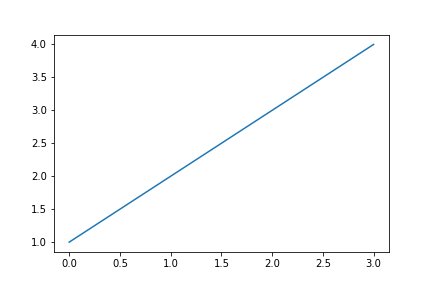

> 2023-01-10 17:56:10,101 [info] starting run functions-log_as_default_artifact_types uid=0deaef7fc450465687bac6a80cae0b4a DB=http://mlrun-api:8080
> 2023-01-10 17:56:10,266 [info] Job is running in the background, pod: functions-log-as-default-artifact-types-znbdb
> 2023-01-10 17:56:16,071 [info] To track results use the CLI: {'info_cmd': 'mlrun get run 0deaef7fc450465687bac6a80cae0b4a -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs 0deaef7fc450465687bac6a80cae0b4a -p mlrun-handler-tests-guyl'}
> 2023-01-10 17:56:16,071 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.cto-office.iguazio-cd1.com/mlprojects/mlrun-handler-tests-guyl/jobs/monitor/0deaef7fc450465687bac6a80cae0b4a/overview'}
> 2023-01-10 17:56:16,072 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...0cae0b4a,0,Jan 10 17:56:14,completed,functions-log_as_default_artifact_types,v3io_user=guylkind=jobowner=guylmlrun/client_version=1.2.1host=functions-log-as-default-artifact-types-znbdb,,,my_result=10my_imputer=SimpleImputer(),my_datasetmy_objectmy_plot


> 2023-01-10 17:56:16,500 [info] run executed, status=completed
> 2023-01-10 17:56:16,501 [info] {'my_result': 10, 'my_imputer': 'SimpleImputer()', 'my_dataset': 'store://artifacts/mlrun-handler-tests-guyl/functions-log_as_default_artifact_types_my_dataset:0deaef7fc450465687bac6a80cae0b4a', 'my_object': 'v3io:///projects/mlrun-handler-tests-guyl/artifacts/functions-log_as_default_artifact_types/0/my_object.pkl', 'my_plot': 'v3io:///projects/mlrun-handler-tests-guyl/artifacts/functions-log_as_default_artifact_types/0/my_plot.html'}
> 2023-01-10 17:56:16,531 [info] downloading v3io:///projects/mlrun-handler-tests-guyl/artifacts/functions-log_as_default_artifact_types/0/my_object.pkl to local temp file



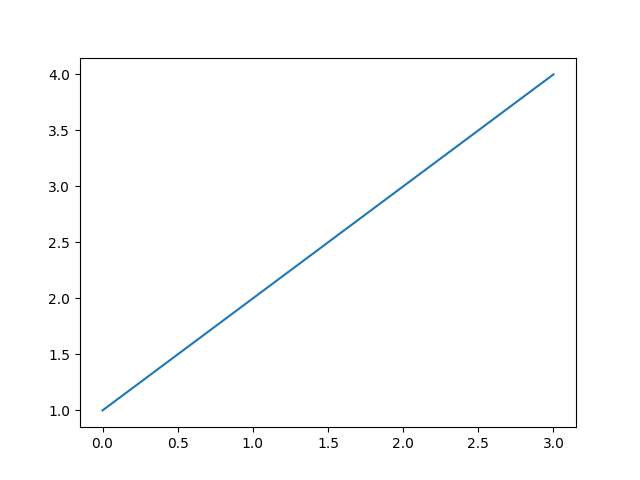

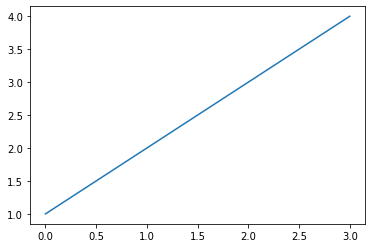

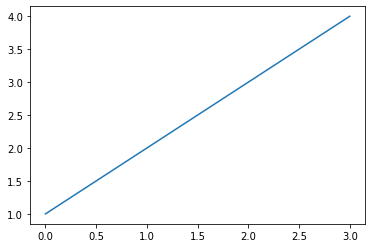

In [21]:
test_log_as_default_artifact_types_without_mlrun()
test_log_as_default_artifact_types_with_mlrun(local=True)
test_log_as_default_artifact_types_with_mlrun(local=False)

### 2.8. Log with `None` Values

Run the `log_with_none_values` function to see the wrapper is logging and ignoring the returned values as needed. Only result type should be logged as None, the dataset is needed to be ignored (not logged).

In [22]:
def test_log_with_none_values_without_mlrun():
    dataset, result, no_type, no_to_log = log_with_none_values()
    assert isinstance(dataset, np.ndarray)
    assert result == 5
    assert isinstance(no_type, np.ndarray)
    assert no_to_log == 10


def test_log_with_none_values_with_mlrun(
    is_none_dataset: bool, is_none_result: bool, is_none_no_type: bool, local: bool
):
    # Run the function:
    run_object = mlrun_function.run(
        handler="log_with_none_values",
        params={
            "is_none_dataset": is_none_dataset,
            "is_none_result": is_none_result,
            "is_none_no_type": is_none_no_type,
        },
        local=local,
    )

    # Manual validation:
    mlrun.utils.logger.info(run_object.outputs)

    # Assertion:
    assert (
        len(run_object.outputs) == (0 if is_none_dataset else 1) + 1 + 1
    )  # dataset only if True, result, no_type
    if not is_none_dataset:
        assert run_object.artifact("dataset").as_df().shape == (5, 5)
    assert run_object.outputs["result"] == "None" if is_none_result else 5
    if is_none_no_type:
        assert run_object.outputs["no_type"] == "None"
    else:
        assert run_object.artifact("no_type").as_df().shape == (10, 10)

In [23]:
test_log_with_none_values_without_mlrun()
for local in [True, False]:
    for is_none_dataset in [True, False]:
        for is_none_result in [True, False]:
            for is_none_no_type in [True, False]:
                test_log_with_none_values_with_mlrun(
                    is_none_dataset=is_none_dataset,
                    is_none_result=is_none_result,
                    is_none_no_type=is_none_no_type,
                    local=local
                )

> 2023-01-10 17:56:16,841 [info] starting run functions-log_with_none_values uid=d2be87b85ced4e16b30356ae4d41cb23 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...4d41cb23,0,Jan 10 17:56:16,completed,functions-log_with_none_values,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-qxpvk,,is_none_dataset=Trueis_none_result=Trueis_none_no_type=True,result=Noneno_type=None,


> 2023-01-10 17:56:17,042 [info] run executed, status=completed
> 2023-01-10 17:56:17,043 [info] {'result': 'None', 'no_type': 'None'}
> 2023-01-10 17:56:17,067 [info] starting run functions-log_with_none_values uid=77c87c83ed5e4c66ad5561be82bd5a5f DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...82bd5a5f,0,Jan 10 17:56:17,completed,functions-log_with_none_values,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-qxpvk,,is_none_dataset=Trueis_none_result=Trueis_none_no_type=False,result=None,no_type


> 2023-01-10 17:56:17,321 [info] run executed, status=completed
> 2023-01-10 17:56:17,321 [info] {'result': 'None', 'no_type': 'store://artifacts/mlrun-handler-tests-guyl/functions-log_with_none_values_no_type:77c87c83ed5e4c66ad5561be82bd5a5f'}
> 2023-01-10 17:56:17,372 [info] starting run functions-log_with_none_values uid=f7d88c4bbe684dd4a2feb41ed86b99ab DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...d86b99ab,0,Jan 10 17:56:17,completed,functions-log_with_none_values,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-qxpvk,,is_none_dataset=Trueis_none_result=Falseis_none_no_type=True,result=5no_type=None,


> 2023-01-10 17:56:17,574 [info] run executed, status=completed
> 2023-01-10 17:56:17,574 [info] {'result': 5, 'no_type': 'None'}
> 2023-01-10 17:56:17,603 [info] starting run functions-log_with_none_values uid=3c72c5f1b4eb416ba729ec023fc63bc8 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...3fc63bc8,0,Jan 10 17:56:17,completed,functions-log_with_none_values,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-qxpvk,,is_none_dataset=Trueis_none_result=Falseis_none_no_type=False,result=5,no_type


> 2023-01-10 17:56:17,862 [info] run executed, status=completed
> 2023-01-10 17:56:17,863 [info] {'result': 5, 'no_type': 'store://artifacts/mlrun-handler-tests-guyl/functions-log_with_none_values_no_type:3c72c5f1b4eb416ba729ec023fc63bc8'}
> 2023-01-10 17:56:17,916 [info] starting run functions-log_with_none_values uid=000b460c19f74d1cb5362304a9d1eb17 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...a9d1eb17,0,Jan 10 17:56:17,completed,functions-log_with_none_values,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-qxpvk,,is_none_dataset=Falseis_none_result=Trueis_none_no_type=True,result=Noneno_type=None,dataset


> 2023-01-10 17:56:18,163 [info] run executed, status=completed
> 2023-01-10 17:56:18,163 [info] {'result': 'None', 'no_type': 'None', 'dataset': 'store://artifacts/mlrun-handler-tests-guyl/functions-log_with_none_values_dataset:000b460c19f74d1cb5362304a9d1eb17'}
> 2023-01-10 17:56:18,214 [info] starting run functions-log_with_none_values uid=72a7d0346e104b55a608db8019b70c85 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...19b70c85,0,Jan 10 17:56:18,completed,functions-log_with_none_values,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-qxpvk,,is_none_dataset=Falseis_none_result=Trueis_none_no_type=False,result=None,datasetno_type


> 2023-01-10 17:56:18,685 [info] run executed, status=completed
> 2023-01-10 17:56:18,686 [info] {'result': 'None', 'dataset': 'store://artifacts/mlrun-handler-tests-guyl/functions-log_with_none_values_dataset:72a7d0346e104b55a608db8019b70c85', 'no_type': 'store://artifacts/mlrun-handler-tests-guyl/functions-log_with_none_values_no_type:72a7d0346e104b55a608db8019b70c85'}
> 2023-01-10 17:56:18,766 [info] starting run functions-log_with_none_values uid=095983fcbd53484c8adfff585a4a1e89 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...5a4a1e89,0,Jan 10 17:56:18,completed,functions-log_with_none_values,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-qxpvk,,is_none_dataset=Falseis_none_result=Falseis_none_no_type=True,result=5no_type=None,dataset


> 2023-01-10 17:56:19,060 [info] run executed, status=completed
> 2023-01-10 17:56:19,061 [info] {'result': 5, 'no_type': 'None', 'dataset': 'store://artifacts/mlrun-handler-tests-guyl/functions-log_with_none_values_dataset:095983fcbd53484c8adfff585a4a1e89'}
> 2023-01-10 17:56:19,114 [info] starting run functions-log_with_none_values uid=65b2fffd315c4fedbc50e3d917bc976d DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...17bc976d,0,Jan 10 17:56:19,completed,functions-log_with_none_values,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-qxpvk,,is_none_dataset=Falseis_none_result=Falseis_none_no_type=False,result=5,datasetno_type


> 2023-01-10 17:56:19,442 [info] run executed, status=completed
> 2023-01-10 17:56:19,443 [info] {'result': 5, 'dataset': 'store://artifacts/mlrun-handler-tests-guyl/functions-log_with_none_values_dataset:65b2fffd315c4fedbc50e3d917bc976d', 'no_type': 'store://artifacts/mlrun-handler-tests-guyl/functions-log_with_none_values_no_type:65b2fffd315c4fedbc50e3d917bc976d'}
> 2023-01-10 17:56:19,522 [info] starting run functions-log_with_none_values uid=1256382cbe5c485f936e971a944acead DB=http://mlrun-api:8080
> 2023-01-10 17:56:19,697 [info] Job is running in the background, pod: functions-log-with-none-values-bx7jt
> 2023-01-10 17:56:25,035 [info] To track results use the CLI: {'info_cmd': 'mlrun get run 1256382cbe5c485f936e971a944acead -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs 1256382cbe5c485f936e971a944acead -p mlrun-handler-tests-guyl'}
> 2023-01-10 17:56:25,036 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.cto-office.iguazio-cd1.com/mlprojects/mlrun

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...944acead,0,Jan 10 17:56:23,completed,functions-log_with_none_values,v3io_user=guylkind=jobowner=guylmlrun/client_version=1.2.1host=functions-log-with-none-values-bx7jt,,is_none_dataset=Trueis_none_result=Trueis_none_no_type=True,result=Noneno_type=None,


> 2023-01-10 17:56:25,914 [info] run executed, status=completed
> 2023-01-10 17:56:25,915 [info] {'result': 'None', 'no_type': 'None'}
> 2023-01-10 17:56:25,939 [info] starting run functions-log_with_none_values uid=93f6ad85785e46028240000742a1c1be DB=http://mlrun-api:8080
> 2023-01-10 17:56:26,120 [info] Job is running in the background, pod: functions-log-with-none-values-5jnd5
> 2023-01-10 17:56:31,699 [info] To track results use the CLI: {'info_cmd': 'mlrun get run 93f6ad85785e46028240000742a1c1be -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs 93f6ad85785e46028240000742a1c1be -p mlrun-handler-tests-guyl'}
> 2023-01-10 17:56:31,699 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.cto-office.iguazio-cd1.com/mlprojects/mlrun-handler-tests-guyl/jobs/monitor/93f6ad85785e46028240000742a1c1be/overview'}
> 2023-01-10 17:56:31,699 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...42a1c1be,0,Jan 10 17:56:29,completed,functions-log_with_none_values,v3io_user=guylkind=jobowner=guylmlrun/client_version=1.2.1host=functions-log-with-none-values-5jnd5,,is_none_dataset=Trueis_none_result=Trueis_none_no_type=False,result=None,no_type


> 2023-01-10 17:56:32,358 [info] run executed, status=completed
> 2023-01-10 17:56:32,359 [info] {'result': 'None', 'no_type': 'store://artifacts/mlrun-handler-tests-guyl/functions-log_with_none_values_no_type:93f6ad85785e46028240000742a1c1be'}
> 2023-01-10 17:56:32,418 [info] starting run functions-log_with_none_values uid=ed22d126f45a4d4ab6e26158c9565512 DB=http://mlrun-api:8080
> 2023-01-10 17:56:32,592 [info] Job is running in the background, pod: functions-log-with-none-values-npkh9
> 2023-01-10 17:56:37,948 [info] To track results use the CLI: {'info_cmd': 'mlrun get run ed22d126f45a4d4ab6e26158c9565512 -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs ed22d126f45a4d4ab6e26158c9565512 -p mlrun-handler-tests-guyl'}
> 2023-01-10 17:56:37,948 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.cto-office.iguazio-cd1.com/mlprojects/mlrun-handler-tests-guyl/jobs/monitor/ed22d126f45a4d4ab6e26158c9565512/overview'}
> 2023-01-10 17:56:37,948 [info] run executed, 

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...c9565512,0,Jan 10 17:56:36,completed,functions-log_with_none_values,v3io_user=guylkind=jobowner=guylmlrun/client_version=1.2.1host=functions-log-with-none-values-npkh9,,is_none_dataset=Trueis_none_result=Falseis_none_no_type=True,result=5no_type=None,


> 2023-01-10 17:56:38,816 [info] run executed, status=completed
> 2023-01-10 17:56:38,816 [info] {'result': 5, 'no_type': 'None'}
> 2023-01-10 17:56:38,839 [info] starting run functions-log_with_none_values uid=b8a54691134c41dd88cd34f509d7af82 DB=http://mlrun-api:8080
> 2023-01-10 17:56:39,000 [info] Job is running in the background, pod: functions-log-with-none-values-lxlrk
> 2023-01-10 17:56:44,414 [info] To track results use the CLI: {'info_cmd': 'mlrun get run b8a54691134c41dd88cd34f509d7af82 -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs b8a54691134c41dd88cd34f509d7af82 -p mlrun-handler-tests-guyl'}
> 2023-01-10 17:56:44,414 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.cto-office.iguazio-cd1.com/mlprojects/mlrun-handler-tests-guyl/jobs/monitor/b8a54691134c41dd88cd34f509d7af82/overview'}
> 2023-01-10 17:56:44,415 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...09d7af82,0,Jan 10 17:56:42,completed,functions-log_with_none_values,v3io_user=guylkind=jobowner=guylmlrun/client_version=1.2.1host=functions-log-with-none-values-lxlrk,,is_none_dataset=Trueis_none_result=Falseis_none_no_type=False,result=5,no_type


> 2023-01-10 17:56:45,242 [info] run executed, status=completed
> 2023-01-10 17:56:45,242 [info] {'result': 5, 'no_type': 'store://artifacts/mlrun-handler-tests-guyl/functions-log_with_none_values_no_type:b8a54691134c41dd88cd34f509d7af82'}
> 2023-01-10 17:56:45,296 [info] starting run functions-log_with_none_values uid=2922e9178d214cde9dd691695cf3aed4 DB=http://mlrun-api:8080
> 2023-01-10 17:56:45,468 [info] Job is running in the background, pod: functions-log-with-none-values-7xgmw
> 2023-01-10 17:56:50,861 [info] To track results use the CLI: {'info_cmd': 'mlrun get run 2922e9178d214cde9dd691695cf3aed4 -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs 2922e9178d214cde9dd691695cf3aed4 -p mlrun-handler-tests-guyl'}
> 2023-01-10 17:56:50,861 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.cto-office.iguazio-cd1.com/mlprojects/mlrun-handler-tests-guyl/jobs/monitor/2922e9178d214cde9dd691695cf3aed4/overview'}
> 2023-01-10 17:56:50,861 [info] run executed, statu

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...5cf3aed4,0,Jan 10 17:56:49,completed,functions-log_with_none_values,v3io_user=guylkind=jobowner=guylmlrun/client_version=1.2.1host=functions-log-with-none-values-7xgmw,,is_none_dataset=Falseis_none_result=Trueis_none_no_type=True,result=Noneno_type=None,dataset


> 2023-01-10 17:56:51,680 [info] run executed, status=completed
> 2023-01-10 17:56:51,680 [info] {'result': 'None', 'no_type': 'None', 'dataset': 'store://artifacts/mlrun-handler-tests-guyl/functions-log_with_none_values_dataset:2922e9178d214cde9dd691695cf3aed4'}
> 2023-01-10 17:56:51,733 [info] starting run functions-log_with_none_values uid=fb93169ef044432bb4c497d902c7c883 DB=http://mlrun-api:8080
> 2023-01-10 17:56:51,914 [info] Job is running in the background, pod: functions-log-with-none-values-w59c5
> 2023-01-10 17:56:57,605 [info] To track results use the CLI: {'info_cmd': 'mlrun get run fb93169ef044432bb4c497d902c7c883 -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs fb93169ef044432bb4c497d902c7c883 -p mlrun-handler-tests-guyl'}
> 2023-01-10 17:56:57,606 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.cto-office.iguazio-cd1.com/mlprojects/mlrun-handler-tests-guyl/jobs/monitor/fb93169ef044432bb4c497d902c7c883/overview'}
> 2023-01-10 17:56:57,606 [i

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...02c7c883,0,Jan 10 17:56:55,completed,functions-log_with_none_values,v3io_user=guylkind=jobowner=guylmlrun/client_version=1.2.1host=functions-log-with-none-values-w59c5,,is_none_dataset=Falseis_none_result=Trueis_none_no_type=False,result=None,datasetno_type


> 2023-01-10 17:56:58,135 [info] run executed, status=completed
> 2023-01-10 17:56:58,136 [info] {'result': 'None', 'dataset': 'store://artifacts/mlrun-handler-tests-guyl/functions-log_with_none_values_dataset:fb93169ef044432bb4c497d902c7c883', 'no_type': 'store://artifacts/mlrun-handler-tests-guyl/functions-log_with_none_values_no_type:fb93169ef044432bb4c497d902c7c883'}
> 2023-01-10 17:56:58,219 [info] starting run functions-log_with_none_values uid=cc4cf4b21faf468d90e065d039f74205 DB=http://mlrun-api:8080
> 2023-01-10 17:56:58,379 [info] Job is running in the background, pod: functions-log-with-none-values-pdjzv
> 2023-01-10 17:57:04,153 [info] To track results use the CLI: {'info_cmd': 'mlrun get run cc4cf4b21faf468d90e065d039f74205 -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs cc4cf4b21faf468d90e065d039f74205 -p mlrun-handler-tests-guyl'}
> 2023-01-10 17:57:04,153 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.cto-office.iguazio-cd1.com/mlprojects/

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...39f74205,0,Jan 10 17:57:02,completed,functions-log_with_none_values,v3io_user=guylkind=jobowner=guylmlrun/client_version=1.2.1host=functions-log-with-none-values-pdjzv,,is_none_dataset=Falseis_none_result=Falseis_none_no_type=True,result=5no_type=None,dataset


> 2023-01-10 17:57:04,614 [info] run executed, status=completed
> 2023-01-10 17:57:04,614 [info] {'result': 5, 'no_type': 'None', 'dataset': 'store://artifacts/mlrun-handler-tests-guyl/functions-log_with_none_values_dataset:cc4cf4b21faf468d90e065d039f74205'}
> 2023-01-10 17:57:04,675 [info] starting run functions-log_with_none_values uid=d94093b081294c088e92ed89e8b1c59d DB=http://mlrun-api:8080
> 2023-01-10 17:57:04,863 [info] Job is running in the background, pod: functions-log-with-none-values-rk96d
> 2023-01-10 17:57:10,702 [info] To track results use the CLI: {'info_cmd': 'mlrun get run d94093b081294c088e92ed89e8b1c59d -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs d94093b081294c088e92ed89e8b1c59d -p mlrun-handler-tests-guyl'}
> 2023-01-10 17:57:10,703 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.cto-office.iguazio-cd1.com/mlprojects/mlrun-handler-tests-guyl/jobs/monitor/d94093b081294c088e92ed89e8b1c59d/overview'}
> 2023-01-10 17:57:10,703 [info] 

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...e8b1c59d,0,Jan 10 17:57:08,completed,functions-log_with_none_values,v3io_user=guylkind=jobowner=guylmlrun/client_version=1.2.1host=functions-log-with-none-values-rk96d,,is_none_dataset=Falseis_none_result=Falseis_none_no_type=False,result=5,datasetno_type


> 2023-01-10 17:57:11,228 [info] run executed, status=completed
> 2023-01-10 17:57:11,228 [info] {'result': 5, 'dataset': 'store://artifacts/mlrun-handler-tests-guyl/functions-log_with_none_values_dataset:d94093b081294c088e92ed89e8b1c59d', 'no_type': 'store://artifacts/mlrun-handler-tests-guyl/functions-log_with_none_values_no_type:d94093b081294c088e92ed89e8b1c59d'}


### 2.9. Log from Function and Wrapper

Run the `log_from_function_and_wrapper` function to see the wrapper is logging the returned values among the other values logged via the context manually inside the function.

In [24]:
def test_log_from_function_and_wrapper_without_mlrun():
    my_dataset, my_result = log_from_function_and_wrapper()
    assert isinstance(my_dataset, list)
    assert isinstance(my_result, str)


def test_log_from_function_and_wrapper_with_mlrun(local: bool):
    # Run the function:
    run_object = mlrun_function.run(
        handler="log_from_function_and_wrapper",
        local=local,
    )

    # Manual validation:
    mlrun.utils.logger.info(run_object.outputs)

    # Assertion:
    assert (
        len(run_object.outputs) == 4
    )  # context_dataset, context_result, wrapper_dataset, wrapper_result
    assert run_object.artifact("context_dataset").as_df().shape == (10, 1)
    assert run_object.outputs["context_result"] == 1
    assert run_object.artifact("wrapper_dataset").as_df().shape == (4, 1)
    assert run_object.outputs["wrapper_result"] == "hello"

In [25]:
test_log_from_function_and_wrapper_without_mlrun()
test_log_from_function_and_wrapper_with_mlrun(local=True)
test_log_from_function_and_wrapper_with_mlrun(local=False)

> 2023-01-10 17:57:11,374 [info] starting run functions-log_from_function_and_wrapper uid=1abc28bc95294dfe9ac7a32d31696288 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...31696288,0,Jan 10 17:57:11,completed,functions-log_from_function_and_wrapper,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-qxpvk,,,context_result=1wrapper_result=hello,context_datasetwrapper_dataset


> 2023-01-10 17:57:11,650 [info] run executed, status=completed
> 2023-01-10 17:57:11,650 [info] {'context_result': 1, 'wrapper_result': 'hello', 'context_dataset': 'store://artifacts/mlrun-handler-tests-guyl/functions-log_from_function_and_wrapper_context_dataset:1abc28bc95294dfe9ac7a32d31696288', 'wrapper_dataset': 'store://artifacts/mlrun-handler-tests-guyl/functions-log_from_function_and_wrapper_wrapper_dataset:1abc28bc95294dfe9ac7a32d31696288'}
> 2023-01-10 17:57:11,753 [info] starting run functions-log_from_function_and_wrapper uid=41968a9e15c3476bb815959ba2506c6b DB=http://mlrun-api:8080
> 2023-01-10 17:57:11,951 [info] Job is running in the background, pod: functions-log-from-function-and-wrapper-4ml96
> 2023-01-10 17:57:17,282 [info] To track results use the CLI: {'info_cmd': 'mlrun get run 41968a9e15c3476bb815959ba2506c6b -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs 41968a9e15c3476bb815959ba2506c6b -p mlrun-handler-tests-guyl'}
> 2023-01-10 17:57:17,282 [info] Or cli

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...a2506c6b,0,Jan 10 17:57:15,completed,functions-log_from_function_and_wrapper,v3io_user=guylkind=jobowner=guylmlrun/client_version=1.2.1host=functions-log-from-function-and-wrapper-4ml96,,,context_result=1wrapper_result=hello,context_datasetwrapper_dataset


> 2023-01-10 17:57:18,166 [info] run executed, status=completed
> 2023-01-10 17:57:18,167 [info] {'context_result': 1, 'wrapper_result': 'hello', 'context_dataset': 'store://artifacts/mlrun-handler-tests-guyl/functions-log_from_function_and_wrapper_context_dataset:41968a9e15c3476bb815959ba2506c6b', 'wrapper_dataset': 'store://artifacts/mlrun-handler-tests-guyl/functions-log_from_function_and_wrapper_wrapper_dataset:41968a9e15c3476bb815959ba2506c6b'}


## 3. Parsing Inputs

### 3.1. Parse Inputs from Type Hints

Run the `parse_inputs_from_type_hints` function to see the wrapper is parsing the given inputs (`DataItem`s) to the written type hints.

In [26]:
def test_parse_inputs_from_type_hints_without_mlrun():
    _, _, _, my_data = log_dataset()
    my_encoder = log_object()
    result = parse_inputs_from_type_hints(
        my_data, my_encoder=my_encoder, data_2=None, data_3=None, add=1
    )
    assert isinstance(result, list)
    assert result == [[2], [3], [4]]


def test_parse_inputs_from_type_hints_with_mlrun(local: bool):
    # Run the following functions to create a dataset and encoder objects:
    log_dataset_run = mlrun_function.run(
        handler="log_dataset",
        local=local,
    )
    log_object_run = mlrun_function.run(
        handler="log_object",
        local=local,
    )

    # Run the function that will parse the data items:
    run_object = mlrun_function.run(
        handler="parse_inputs_from_type_hints",
        inputs={
            "my_data": log_dataset_run.outputs["my_list"],
            "my_encoder": log_object_run.outputs["my_object"],
            "data_2": log_dataset_run.outputs["my_array"],
            "data_3": log_dataset_run.outputs["my_dict"],
        },
        params={"add": 1},
        local=local,
    )

    # Manual validation:
    mlrun.utils.logger.info(run_object.outputs)

    # Assertion:
    assert len(run_object.outputs) == 0

In [27]:
test_parse_inputs_from_type_hints_without_mlrun()
test_parse_inputs_from_type_hints_with_mlrun(local=True)
test_parse_inputs_from_type_hints_with_mlrun(local=False)

> 2023-01-10 17:57:18,362 [info] starting run functions-log_dataset uid=a944402b77c24cab8b010526faf267c4 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...faf267c4,0,Jan 10 17:57:18,completed,functions-log_dataset,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-qxpvk,,,,my_arraymy_dfmy_dictmy_list


> 2023-01-10 17:57:18,784 [info] run executed, status=completed
> 2023-01-10 17:57:18,808 [info] starting run functions-log_object uid=b09b14495fbf46358319103c0dc295a9 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...0dc295a9,0,Jan 10 17:57:18,completed,functions-log_object,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-qxpvk,,,,my_object


> 2023-01-10 17:57:19,053 [info] run executed, status=completed
> 2023-01-10 17:57:19,083 [info] starting run functions-parse_inputs_from_type_hints uid=4386a46fdd9c477699613753cc3ed488 DB=http://mlrun-api:8080
> 2023-01-10 17:57:19,389 [info] downloading v3io:///projects/mlrun-handler-tests-guyl/artifacts/functions-log_object/0/my_object.pkl to local temp file


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...cc3ed488,0,Jan 10 17:57:19,completed,functions-parse_inputs_from_type_hints,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-qxpvk,my_datamy_encoderdata_2data_3,add=1,,


> 2023-01-10 17:57:19,473 [info] run executed, status=completed
> 2023-01-10 17:57:19,474 [info] {}
> 2023-01-10 17:57:19,499 [info] starting run functions-log_dataset uid=f3882a62e23b4e1e9e2869c695f4096a DB=http://mlrun-api:8080
> 2023-01-10 17:57:19,658 [info] Job is running in the background, pod: functions-log-dataset-sc54q
> 2023-01-10 17:57:25,300 [info] To track results use the CLI: {'info_cmd': 'mlrun get run f3882a62e23b4e1e9e2869c695f4096a -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs f3882a62e23b4e1e9e2869c695f4096a -p mlrun-handler-tests-guyl'}
> 2023-01-10 17:57:25,300 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.cto-office.iguazio-cd1.com/mlprojects/mlrun-handler-tests-guyl/jobs/monitor/f3882a62e23b4e1e9e2869c695f4096a/overview'}
> 2023-01-10 17:57:25,301 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...95f4096a,0,Jan 10 17:57:23,completed,functions-log_dataset,v3io_user=guylkind=jobowner=guylmlrun/client_version=1.2.1host=functions-log-dataset-sc54q,,,,my_arraymy_dfmy_dictmy_list


> 2023-01-10 17:57:25,928 [info] run executed, status=completed
> 2023-01-10 17:57:25,952 [info] starting run functions-log_object uid=ad89d144bbe84202a04512ae571aa720 DB=http://mlrun-api:8080
> 2023-01-10 17:57:26,123 [info] Job is running in the background, pod: functions-log-object-xv4c5
> 2023-01-10 17:57:31,566 [info] To track results use the CLI: {'info_cmd': 'mlrun get run ad89d144bbe84202a04512ae571aa720 -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs ad89d144bbe84202a04512ae571aa720 -p mlrun-handler-tests-guyl'}
> 2023-01-10 17:57:31,566 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.cto-office.iguazio-cd1.com/mlprojects/mlrun-handler-tests-guyl/jobs/monitor/ad89d144bbe84202a04512ae571aa720/overview'}
> 2023-01-10 17:57:31,567 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...571aa720,0,Jan 10 17:57:29,completed,functions-log_object,v3io_user=guylkind=jobowner=guylmlrun/client_version=1.2.1host=functions-log-object-xv4c5,,,,my_object


> 2023-01-10 17:57:32,355 [info] run executed, status=completed
> 2023-01-10 17:57:32,378 [info] starting run functions-parse_inputs_from_type_hints uid=42abb180207840108fcfb50e252b0d2a DB=http://mlrun-api:8080
> 2023-01-10 17:57:32,541 [info] Job is running in the background, pod: functions-parse-inputs-from-type-hints-xlmfp
> 2023-01-10 17:57:38,109 [info] downloading v3io:///projects/mlrun-handler-tests-guyl/artifacts/functions-log_object/0/my_object.pkl to local temp file
> 2023-01-10 17:57:38,151 [info] To track results use the CLI: {'info_cmd': 'mlrun get run 42abb180207840108fcfb50e252b0d2a -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs 42abb180207840108fcfb50e252b0d2a -p mlrun-handler-tests-guyl'}
> 2023-01-10 17:57:38,151 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.cto-office.iguazio-cd1.com/mlprojects/mlrun-handler-tests-guyl/jobs/monitor/42abb180207840108fcfb50e252b0d2a/overview'}
> 2023-01-10 17:57:38,151 [info] run executed, status=compl

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...252b0d2a,0,Jan 10 17:57:36,completed,functions-parse_inputs_from_type_hints,v3io_user=guylkind=jobowner=guylmlrun/client_version=1.2.1host=functions-parse-inputs-from-type-hints-xlmfp,my_datamy_encoderdata_2data_3,add=1,,


> 2023-01-10 17:57:38,760 [info] run executed, status=completed
> 2023-01-10 17:57:38,760 [info] {}


### 3.2. Parse Inputs from Wrapper

Run the `parse_inputs_from_wrapper` function to see the wrapper is parsing the given inputs (`DataItem`s) to the written configuration provided to the wrapper.

In [28]:
def test_parse_inputs_from_wrapper_without_mlrun():
    _, _, _, my_data = log_dataset()
    my_encoder = log_object()
    result = parse_inputs_from_wrapper(
        pd.DataFrame(my_data), my_encoder=my_encoder, add=1
    )
    assert isinstance(result, list)
    assert result == [[2], [3], [4]]


def test_parse_inputs_from_wrapper_with_mlrun(local: bool):
    # Run the following functions to create a dataset and encoder objects:
    log_dataset_run = mlrun_function.run(
        handler="log_dataset",
        local=local,
    )
    log_object_run = mlrun_function.run(
        handler="log_object",
        local=local,
    )

    # Run the function that will parse the data items:
    run_object = mlrun_function.run(
        handler="parse_inputs_from_wrapper",
        inputs={
            "my_data": log_dataset_run.outputs["my_list"],
            "my_encoder": log_object_run.outputs["my_object"],
        },
        params={"add": 1},
        local=local,
    )

    # Manual validation:
    mlrun.utils.logger.info(run_object.outputs)

    # Assertion:
    assert len(run_object.outputs) == 0  # return

In [29]:
test_parse_inputs_from_wrapper_without_mlrun()
test_parse_inputs_from_wrapper_with_mlrun(local=True)
test_parse_inputs_from_wrapper_with_mlrun(local=False)

> 2023-01-10 17:57:38,906 [info] starting run functions-log_dataset uid=fd1f4b383ccd43e6ab23c73a7acd2601 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...7acd2601,0,Jan 10 17:57:38,completed,functions-log_dataset,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-qxpvk,,,,my_arraymy_dfmy_dictmy_list


> 2023-01-10 17:57:39,379 [info] run executed, status=completed
> 2023-01-10 17:57:39,403 [info] starting run functions-log_object uid=caebc61eb3ce43808f32a5ee64dac2e3 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...64dac2e3,0,Jan 10 17:57:39,completed,functions-log_object,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-qxpvk,,,,my_object


> 2023-01-10 17:57:39,776 [info] run executed, status=completed
> 2023-01-10 17:57:39,803 [info] starting run functions-parse_inputs_from_wrapper uid=70761be120464225b3f6b33799a103f4 DB=http://mlrun-api:8080
> 2023-01-10 17:57:40,021 [info] downloading v3io:///projects/mlrun-handler-tests-guyl/artifacts/functions-log_object/0/my_object.pkl to local temp file


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...99a103f4,0,Jan 10 17:57:39,completed,functions-parse_inputs_from_wrapper,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-qxpvk,my_datamy_encoder,add=1,,


> 2023-01-10 17:57:40,118 [info] run executed, status=completed
> 2023-01-10 17:57:40,119 [info] {}
> 2023-01-10 17:57:40,146 [info] starting run functions-log_dataset uid=452c402448854d3f88d6d275aaeb8957 DB=http://mlrun-api:8080
> 2023-01-10 17:57:40,338 [info] Job is running in the background, pod: functions-log-dataset-jffds
> 2023-01-10 17:57:45,993 [info] To track results use the CLI: {'info_cmd': 'mlrun get run 452c402448854d3f88d6d275aaeb8957 -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs 452c402448854d3f88d6d275aaeb8957 -p mlrun-handler-tests-guyl'}
> 2023-01-10 17:57:45,994 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.cto-office.iguazio-cd1.com/mlprojects/mlrun-handler-tests-guyl/jobs/monitor/452c402448854d3f88d6d275aaeb8957/overview'}
> 2023-01-10 17:57:45,994 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...aaeb8957,0,Jan 10 17:57:44,completed,functions-log_dataset,v3io_user=guylkind=jobowner=guylmlrun/client_version=1.2.1host=functions-log-dataset-jffds,,,,my_arraymy_dfmy_dictmy_list


> 2023-01-10 17:57:46,566 [info] run executed, status=completed
> 2023-01-10 17:57:46,590 [info] starting run functions-log_object uid=8df899838540418b91ddc5e36cc29afc DB=http://mlrun-api:8080
> 2023-01-10 17:57:46,751 [info] Job is running in the background, pod: functions-log-object-5l5rk
> 2023-01-10 17:57:52,214 [info] To track results use the CLI: {'info_cmd': 'mlrun get run 8df899838540418b91ddc5e36cc29afc -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs 8df899838540418b91ddc5e36cc29afc -p mlrun-handler-tests-guyl'}
> 2023-01-10 17:57:52,214 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.cto-office.iguazio-cd1.com/mlprojects/mlrun-handler-tests-guyl/jobs/monitor/8df899838540418b91ddc5e36cc29afc/overview'}
> 2023-01-10 17:57:52,215 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...6cc29afc,0,Jan 10 17:57:50,completed,functions-log_object,v3io_user=guylkind=jobowner=guylmlrun/client_version=1.2.1host=functions-log-object-5l5rk,,,,my_object


> 2023-01-10 17:57:52,975 [info] run executed, status=completed
> 2023-01-10 17:57:52,999 [info] starting run functions-parse_inputs_from_wrapper uid=10bc738aa8c54080b97e146e7f531de6 DB=http://mlrun-api:8080
> 2023-01-10 17:57:53,166 [info] Job is running in the background, pod: functions-parse-inputs-from-wrapper-24jrz
> 2023-01-10 17:57:58,696 [info] downloading v3io:///projects/mlrun-handler-tests-guyl/artifacts/functions-log_object/0/my_object.pkl to local temp file
> 2023-01-10 17:57:58,746 [info] To track results use the CLI: {'info_cmd': 'mlrun get run 10bc738aa8c54080b97e146e7f531de6 -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs 10bc738aa8c54080b97e146e7f531de6 -p mlrun-handler-tests-guyl'}
> 2023-01-10 17:57:58,746 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.cto-office.iguazio-cd1.com/mlprojects/mlrun-handler-tests-guyl/jobs/monitor/10bc738aa8c54080b97e146e7f531de6/overview'}
> 2023-01-10 17:57:58,746 [info] run executed, status=completed
f

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...7f531de6,0,Jan 10 17:57:56,completed,functions-parse_inputs_from_wrapper,v3io_user=guylkind=jobowner=guylmlrun/client_version=1.2.1host=functions-parse-inputs-from-wrapper-24jrz,my_datamy_encoder,add=1,,


> 2023-01-10 17:57:59,408 [info] run executed, status=completed
> 2023-01-10 17:57:59,408 [info] {}


## 4. Raising Errors

### 4.1. Raise Error while Logging

Run the `log_from_function_and_wrapper` function to see the wrapper is logging the returned values among the other values logged via the context manually inside the function.

In [30]:
def test_raise_error_while_logging_with_mlrun(local: bool):
    # Run and expect an error:
    try:
        mlrun_function.run(
            handler="raise_error_while_logging",
            local=local,
        )
        assert False
    except Exception as e:
        mlrun.utils.logger.info(e)
        assert "MLRun tried to log 'error_numpy' as " in str(e)

In [31]:
test_raise_error_while_logging_with_mlrun(local=True)
test_raise_error_while_logging_with_mlrun(local=False)

> 2023-01-10 17:57:59,450 [info] starting run functions-raise_error_while_logging uid=063e97f8f44c44d4b85da408ee238f66 DB=http://mlrun-api:8080
> 2023-01-10 17:57:59,615 [error] Traceback (most recent call last):
  File "/User/.pythonlibs/jupyter-guyl/lib/python3.7/site-packages/mlrun/run.py", line 1932, in _log_output
    logging_kwargs=logging_kwargs,
  File "/User/.pythonlibs/jupyter-guyl/lib/python3.7/site-packages/mlrun/run.py", line 1360, in log_dataset
    obj = pd.DataFrame(obj)
  File "/User/.pythonlibs/jupyter-guyl/lib/python3.7/site-packages/pandas/core/frame.py", line 678, in __init__
    typ=manager,
  File "/User/.pythonlibs/jupyter-guyl/lib/python3.7/site-packages/pandas/core/internals/construction.py", line 304, in ndarray_to_mgr
    values = _prep_ndarray(values, copy=copy)
  File "/User/.pythonlibs/jupyter-guyl/lib/python3.7/site-packages/pandas/core/internals/construction.py", line 555, in _prep_ndarray
    raise ValueError(f"Must pass 2-d input. shape={values.shape}

MLRun tried to log 'error_numpy' as 'dataset' but failed. If you didn't provide the artifact type and the default one does not fit, try to select the correct type from the enum `ArtifactType`.


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...ee238f66,0,Jan 10 17:57:59,error,functions-raise_error_while_logging,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-qxpvk,,,,


> 2023-01-10 17:57:59,740 [info] run executed, status=error
> 2023-01-10 17:57:59,741 [info] MLRun tried to log 'error_numpy' as 'dataset' but failed. If you didn't provide the artifact type and the default one does not fit, try to select the correct type from the enum `ArtifactType`.
> 2023-01-10 17:57:59,770 [info] starting run functions-raise_error_while_logging uid=d227cda334034536963522f1f6d05f04 DB=http://mlrun-api:8080
> 2023-01-10 17:57:59,991 [info] Job is running in the background, pod: functions-raise-error-while-logging-v6x82
> 2023-01-10 17:58:05,339 [error] Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/mlrun/run.py", line 1932, in _log_output
    logging_kwargs=logging_kwargs,
  File "/usr/local/lib/python3.7/site-packages/mlrun/run.py", line 1360, in log_dataset
    obj = pd.DataFrame(obj)
  File "/usr/local/lib/python3.7/site-packages/pandas/core/frame.py", line 678, in __init__
    typ=manager,
  File "/usr/local/lib/python3.7/site-p

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...f6d05f04,0,Jan 10 17:58:03,error,functions-raise_error_while_logging,v3io_user=guylkind=jobowner=guylmlrun/client_version=1.2.1host=functions-raise-error-while-logging-v6x82,,,,


> 2023-01-10 17:58:06,225 [info] run executed, status=error
> 2023-01-10 17:58:06,226 [error] runtime error: MLRun tried to log 'error_numpy' as 'dataset' but failed. If you didn't provide the artifact type and the default one does not fit, try to select the correct type from the enum `ArtifactType`.
> 2023-01-10 17:58:06,226 [info] MLRun tried to log 'error_numpy' as 'dataset' but failed. If you didn't provide the artifact type and the default one does not fit, try to select the correct type from the enum `ArtifactType`.


### 4.2. Raise Error while Parsing

Run the `parse_inputs_from_wrapper` function and send it wrong types to see the wrapper is raising the relevant exception.

In [32]:
def test_raise_error_while_parsing_with_mlrun(local: bool):
    # Run the following functions to create a dataset and encoder objects:
    log_dataset_run = mlrun_function.run(
        handler="log_dataset",
        local=local,
    )
    log_object_run = mlrun_function.run(
        handler="log_object",
        local=local,
    )

    # Run the function that will parse the data items and expect an error:
    try:
        mlrun_function.run(
            handler="parse_inputs_from_wrapper",
            inputs={
                "my_data": log_object_run.outputs["my_object"],
                "my_encoder": log_dataset_run.outputs["my_list"],
            },
            params={"add": 1},
            local=local,
        )
        assert False
    except Exception as e:
        mlrun.utils.logger.info(e)
        assert "MLRun tried to parse a `DataItem` of type " in str(e)

In [33]:
test_raise_error_while_parsing_with_mlrun(local=True)
test_raise_error_while_parsing_with_mlrun(local=False)

> 2023-01-10 17:58:06,271 [info] starting run functions-log_dataset uid=85d47e71a2464646a30352f3b04bcf67 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...b04bcf67,0,Jan 10 17:58:06,completed,functions-log_dataset,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-qxpvk,,,,my_arraymy_dfmy_dictmy_list


> 2023-01-10 17:58:06,749 [info] run executed, status=completed
> 2023-01-10 17:58:06,773 [info] starting run functions-log_object uid=833d53b87fb1444ebc90f1a04af2a17b DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...4af2a17b,0,Jan 10 17:58:06,completed,functions-log_object,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-qxpvk,,,,my_object


> 2023-01-10 17:58:07,009 [info] run executed, status=completed
> 2023-01-10 17:58:07,033 [info] starting run functions-parse_inputs_from_wrapper uid=fb68cc922a304ab1a255fa43ece1491f DB=http://mlrun-api:8080
> 2023-01-10 17:58:07,229 [error] Traceback (most recent call last):
  File "/User/.pythonlibs/jupyter-guyl/lib/python3.7/site-packages/mlrun/run.py", line 1890, in _parse_input
    )(data_item=data_item)
  File "/User/.pythonlibs/jupyter-guyl/lib/python3.7/site-packages/mlrun/run.py", line 1293, in parse_numpy_array
    return data_item.as_df().to_numpy()
  File "/User/.pythonlibs/jupyter-guyl/lib/python3.7/site-packages/mlrun/datastore/base.py", line 394, in as_df
    **kwargs,
  File "/User/.pythonlibs/jupyter-guyl/lib/python3.7/site-packages/mlrun/datastore/base.py", line 190, in as_df
    raise Exception(f"file type unhandled {url}")
Exception: file type unhandled v3io:///projects/mlrun-handler-tests-guyl/artifacts/functions-log_object/0/my_object.pkl

The above exception was 

MLRun tried to parse a `DataItem` of type '<class 'numpy.ndarray'>' but failed. Be sure the item was logged correctly - as the type you are trying to parse it back to. In general, python objects should be logged as pickles.


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...ece1491f,0,Jan 10 17:58:07,"' but failed. Be sure the item was logged correctly - as the type you are trying to parse it back to. In general, python objects should be logged as pickles."">error",functions-parse_inputs_from_wrapper,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-qxpvk,my_datamy_encoder,add=1,,


> 2023-01-10 17:58:07,358 [info] run executed, status=error
> 2023-01-10 17:58:07,358 [info] MLRun tried to parse a `DataItem` of type '<class 'numpy.ndarray'>' but failed. Be sure the item was logged correctly - as the type you are trying to parse it back to. In general, python objects should be logged as pickles.
> 2023-01-10 17:58:07,382 [info] starting run functions-log_dataset uid=d8c04d0ad875478ca2aa166fe15e0629 DB=http://mlrun-api:8080
> 2023-01-10 17:58:07,561 [info] Job is running in the background, pod: functions-log-dataset-f2sck
> 2023-01-10 17:58:13,064 [info] To track results use the CLI: {'info_cmd': 'mlrun get run d8c04d0ad875478ca2aa166fe15e0629 -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs d8c04d0ad875478ca2aa166fe15e0629 -p mlrun-handler-tests-guyl'}
> 2023-01-10 17:58:13,064 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.cto-office.iguazio-cd1.com/mlprojects/mlrun-handler-tests-guyl/jobs/monitor/d8c04d0ad875478ca2aa166fe15e0629/over

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...e15e0629,0,Jan 10 17:58:11,completed,functions-log_dataset,v3io_user=guylkind=jobowner=guylmlrun/client_version=1.2.1host=functions-log-dataset-f2sck,,,,my_arraymy_dfmy_dictmy_list


> 2023-01-10 17:58:13,809 [info] run executed, status=completed
> 2023-01-10 17:58:13,840 [info] starting run functions-log_object uid=4902bda5dc9c470789979c3811b04946 DB=http://mlrun-api:8080
> 2023-01-10 17:58:14,028 [info] Job is running in the background, pod: functions-log-object-hfxqc
> 2023-01-10 17:58:19,537 [info] To track results use the CLI: {'info_cmd': 'mlrun get run 4902bda5dc9c470789979c3811b04946 -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs 4902bda5dc9c470789979c3811b04946 -p mlrun-handler-tests-guyl'}
> 2023-01-10 17:58:19,537 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.cto-office.iguazio-cd1.com/mlprojects/mlrun-handler-tests-guyl/jobs/monitor/4902bda5dc9c470789979c3811b04946/overview'}
> 2023-01-10 17:58:19,537 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...11b04946,0,Jan 10 17:58:17,completed,functions-log_object,v3io_user=guylkind=jobowner=guylmlrun/client_version=1.2.1host=functions-log-object-hfxqc,,,,my_object


> 2023-01-10 17:58:20,248 [info] run executed, status=completed
> 2023-01-10 17:58:20,278 [info] starting run functions-parse_inputs_from_wrapper uid=04e4f82eb2f84a47a903a2ccb861d587 DB=http://mlrun-api:8080
> 2023-01-10 17:58:20,451 [info] Job is running in the background, pod: functions-parse-inputs-from-wrapper-hfwsp
> 2023-01-10 17:58:25,893 [error] Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/mlrun/run.py", line 1890, in _parse_input
    )(data_item=data_item)
  File "/usr/local/lib/python3.7/site-packages/mlrun/run.py", line 1293, in parse_numpy_array
    return data_item.as_df().to_numpy()
  File "/usr/local/lib/python3.7/site-packages/mlrun/datastore/base.py", line 394, in as_df
    **kwargs,
  File "/usr/local/lib/python3.7/site-packages/mlrun/datastore/base.py", line 190, in as_df
    raise Exception(f"file type unhandled {url}")
Exception: file type unhandled v3io:///projects/mlrun-handler-tests-guyl/artifacts/functions-log_object/0/my_ob

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...b861d587,0,Jan 10 17:58:24,"' but failed. Be sure the item was logged correctly - as the type you are trying to parse it back to. In general, python objects should be logged as pickles."">error",functions-parse_inputs_from_wrapper,v3io_user=guylkind=jobowner=guylmlrun/client_version=1.2.1host=functions-parse-inputs-from-wrapper-hfwsp,my_datamy_encoder,add=1,,


> 2023-01-10 17:58:26,668 [info] run executed, status=error
> 2023-01-10 17:58:26,669 [error] runtime error: MLRun tried to parse a `DataItem` of type '<class 'numpy.ndarray'>' but failed. Be sure the item was logged correctly - as the type you are trying to parse it back to. In general, python objects should be logged as pickles.
> 2023-01-10 17:58:26,669 [info] MLRun tried to parse a `DataItem` of type '<class 'numpy.ndarray'>' but failed. Be sure the item was logged correctly - as the type you are trying to parse it back to. In general, python objects should be logged as pickles.


## 5. Supporting class methods

Run multiple decorated methods of the class `MyClass` to see the decorator is working as expected (even on class methods). 

In [34]:
def test_class_methods_without_mlrun():
    my_class = MyClass(class_parameter=1)

    my_array, my_df, my_dict, my_list = my_class.log_dataset()
    assert isinstance(my_array, np.ndarray)
    assert isinstance(my_df, pd.DataFrame)
    assert isinstance(my_dict, dict)
    assert isinstance(my_list, list)

    my_object = my_class.log_object()
    assert isinstance(my_object, Pipeline)
    assert my_object.transform([["A"], ["B"], [""]]).tolist() == [[0], [1], [2]]

    result = my_class.parse_inputs_from_type_hints(
        my_list, my_encoder=my_object, data_2=None, data_3=None, mul=2
    )
    assert result == 9


def test_class_methods_with_mlrun(local: bool):
    # Run the following functions to create a dataset and encoder objects:
    log_dataset_run = mlrun_function.run(
        handler="MyClass::log_dataset",
        params={"_init_args": {"class_parameter": 1}},
        local=local,
    )
    log_object_run = mlrun_function.run(
        handler="MyClass::log_object",
        params={"_init_args": {"class_parameter": 1}},
        local=local,
    )

    # Run the function that will parse the data items:
    run_object = mlrun_function.run(
        handler="MyClass::parse_inputs_from_type_hints",
        inputs={
            "my_data": log_dataset_run.outputs["my_list"],
            "my_encoder": log_object_run.outputs["my_object"],
            "data_2": log_dataset_run.outputs["my_array"],
            "data_3": log_dataset_run.outputs["my_dict"],
        },
        params={"_init_args": {"class_parameter": 1}, "mul": 2},
        local=local,
    )

    # Manual validation:
    mlrun.utils.logger.info(run_object.outputs)

    # Assertion:
    assert len(run_object.outputs) == 1
    assert run_object.outputs["result"] == 9

In [35]:
test_class_methods_without_mlrun()
test_class_methods_with_mlrun(local=True)
test_class_methods_with_mlrun(local=False)

> 2023-01-10 17:58:26,811 [info] starting run functions-log_dataset uid=a305976f5023419a828a41e19dfa038b DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...9dfa038b,0,Jan 10 17:58:26,completed,functions-log_dataset,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-qxpvk,,_init_args={'class_parameter': 1},,my_arraymy_dfmy_dictmy_list


> 2023-01-10 17:58:27,235 [info] run executed, status=completed
> 2023-01-10 17:58:27,260 [info] starting run functions-log_object uid=8a338f71b6ab4769942269dcaafc4c12 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...aafc4c12,0,Jan 10 17:58:27,completed,functions-log_object,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-qxpvk,,_init_args={'class_parameter': 1},,my_object


> 2023-01-10 17:58:27,493 [info] run executed, status=completed
> 2023-01-10 17:58:27,519 [info] starting run functions-parse_inputs_from_type_hints uid=7e9fa056433a49759ed910c704a44e5b DB=http://mlrun-api:8080
> 2023-01-10 17:58:27,814 [info] downloading v3io:///projects/mlrun-handler-tests-guyl/artifacts/functions-log_object/0/my_object.pkl to local temp file


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...04a44e5b,0,Jan 10 17:58:27,completed,functions-parse_inputs_from_type_hints,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-qxpvk,my_datamy_encoderdata_2data_3,_init_args={'class_parameter': 1}mul=2,result=9,


> 2023-01-10 17:58:27,893 [info] run executed, status=completed
> 2023-01-10 17:58:27,894 [info] {'result': 9}
> 2023-01-10 17:58:27,917 [info] starting run functions-log_dataset uid=b9c00ffc867145dca98db1b403f2fd7e DB=http://mlrun-api:8080
> 2023-01-10 17:58:28,089 [info] Job is running in the background, pod: functions-log-dataset-mkp95
> 2023-01-10 17:58:33,679 [info] To track results use the CLI: {'info_cmd': 'mlrun get run b9c00ffc867145dca98db1b403f2fd7e -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs b9c00ffc867145dca98db1b403f2fd7e -p mlrun-handler-tests-guyl'}
> 2023-01-10 17:58:33,680 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.cto-office.iguazio-cd1.com/mlprojects/mlrun-handler-tests-guyl/jobs/monitor/b9c00ffc867145dca98db1b403f2fd7e/overview'}
> 2023-01-10 17:58:33,680 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...03f2fd7e,0,Jan 10 17:58:31,completed,functions-log_dataset,v3io_user=guylkind=jobowner=guylmlrun/client_version=1.2.1host=functions-log-dataset-mkp95,,_init_args={'class_parameter': 1},,my_arraymy_dfmy_dictmy_list


> 2023-01-10 17:58:34,321 [info] run executed, status=completed
> 2023-01-10 17:58:34,346 [info] starting run functions-log_object uid=a301e346fe3148faaf87463b13d4b551 DB=http://mlrun-api:8080
> 2023-01-10 17:58:34,518 [info] Job is running in the background, pod: functions-log-object-chjw2
> 2023-01-10 17:58:39,996 [info] To track results use the CLI: {'info_cmd': 'mlrun get run a301e346fe3148faaf87463b13d4b551 -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs a301e346fe3148faaf87463b13d4b551 -p mlrun-handler-tests-guyl'}
> 2023-01-10 17:58:39,996 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.cto-office.iguazio-cd1.com/mlprojects/mlrun-handler-tests-guyl/jobs/monitor/a301e346fe3148faaf87463b13d4b551/overview'}
> 2023-01-10 17:58:39,996 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...13d4b551,0,Jan 10 17:58:38,completed,functions-log_object,v3io_user=guylkind=jobowner=guylmlrun/client_version=1.2.1host=functions-log-object-chjw2,,_init_args={'class_parameter': 1},,my_object


> 2023-01-10 17:58:40,767 [info] run executed, status=completed
> 2023-01-10 17:58:40,791 [info] starting run functions-parse_inputs_from_type_hints uid=ed64ae40705e43d3b464c29b87f80e87 DB=http://mlrun-api:8080
> 2023-01-10 17:58:40,973 [info] Job is running in the background, pod: functions-parse-inputs-from-type-hints-jl7wq
> 2023-01-10 17:58:46,642 [info] downloading v3io:///projects/mlrun-handler-tests-guyl/artifacts/functions-log_object/0/my_object.pkl to local temp file
> 2023-01-10 17:58:46,685 [info] To track results use the CLI: {'info_cmd': 'mlrun get run ed64ae40705e43d3b464c29b87f80e87 -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs ed64ae40705e43d3b464c29b87f80e87 -p mlrun-handler-tests-guyl'}
> 2023-01-10 17:58:46,685 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.cto-office.iguazio-cd1.com/mlprojects/mlrun-handler-tests-guyl/jobs/monitor/ed64ae40705e43d3b464c29b87f80e87/overview'}
> 2023-01-10 17:58:46,686 [info] run executed, status=compl

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...87f80e87,0,Jan 10 17:58:44,completed,functions-parse_inputs_from_type_hints,v3io_user=guylkind=jobowner=guylmlrun/client_version=1.2.1host=functions-parse-inputs-from-type-hints-jl7wq,my_datamy_encoderdata_2data_3,_init_args={'class_parameter': 1}mul=2,result=9,


> 2023-01-10 17:58:47,440 [info] run executed, status=completed
> 2023-01-10 17:58:47,441 [info] {'result': 9}


## Cleanup

In [36]:
# Delete the MLRun project:
mlrun.get_run_db().delete_project(name=project.name, deletion_strategy="cascading")